<a href="https://colab.research.google.com/github/americanthinker/vectorsearch-applications/blob/main/notebooks/4-Reranking_Week2.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Week 2: Building Advanced RAG Applications.  Authored by Chris Sanchez.

# Week 2 - Notebook 4

# Overview

Welcome to Week 2 of the course!  We covered a lot of content last week in order to get to the point where we can search over our data.  In this notebook, you'll have the chance to improve your baseline retrieval scores by combining the strengths of keyword and vector search using Weaviate's `hybrid_search` method.  We'll also incorporate the use of a CrossEncoder reranker to pack the final punch in our retrieved hits, before we pass those results to the LLM for answer synthesis.  Here's a reminder of where we've been and where we're going:

#### Week One
* ~Part 1:~
  * ~Data ingest and preprocessing~
  * ~Convert text into vectors~
* ~Part 2~:
  * ~Index data on Weaviate database~
  * ~Search over data~
* ~Part 2.5~:
  * ~Benchmark retrieval results~

#### Week Two
* **Part 4 (THIS NOTEBOOK)**:
  * **Add Hybrid Search and ReRanker to the mix (new benchmark)**
* Part 5:
  * LLM Integration

#### This notebook will cover the highlighted portion of the technical diagram below, as initially referenced in the Course content:

![arch diagram]( 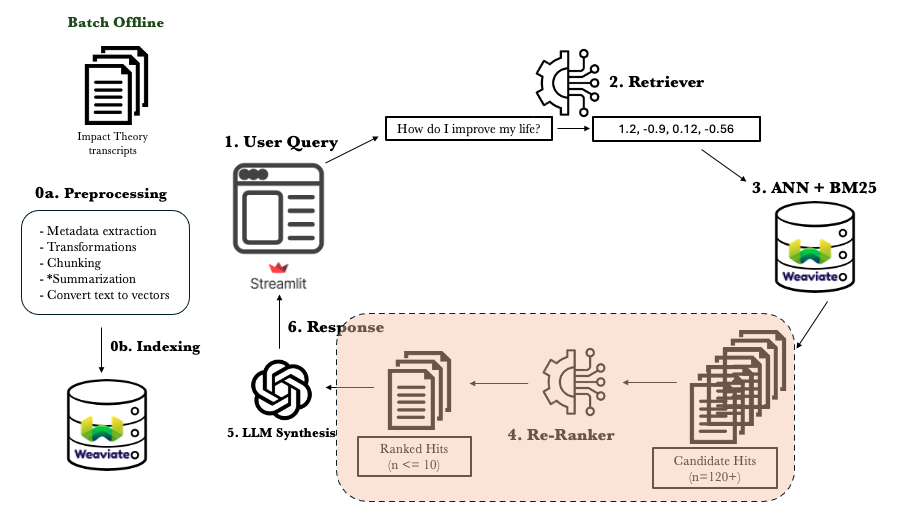)

In [40]:
import sys
sys.path.append('../')

#load from local .env file
from dotenv import load_dotenv, find_dotenv
env = load_dotenv('.env', override=True)

#standard python
from typing import List, Dict, Tuple
import os

# external libraries
from tqdm import tqdm
from rich import print  # nice library that provides improved printing output (overrides default print function)

# external files
from src.reranker import ReRanker
from src.database.weaviate_interface_v4 import WeaviateWCS

## Setup 
***

### Instaniate Weaviate Client

In [41]:
#read env vars from local .env file
api_key = os.environ['WEAVIATE_API_KEY']
url = os.environ['WEAVIATE_ENDPOINT']

model_name = "sentence-transformers/all-MiniLM-L6-v2"

#instantiate client
client = WeaviateWCS(endpoint=url, api_key=api_key, model_name_or_path=model_name)

/var/folders/zz/f8svd2n5583dff32w3y0k5zh0000gn/T/ipykernel_66568/3667173982.py:8: ResourceWarning: unclosed <ssl.SSLSocket fd=80, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('192.168.1.50', 53714), raddr=('34.149.137.116', 443)>
  client = WeaviateWCS(endpoint=url, api_key=api_key, model_name_or_path=model_name)


In [42]:
#display available collection names on cluster
client.show_all_collections()

['Huberman_all_minilm_l6_v2_128',
 'Huberman_all_minilm_l6_v2_256',
 'Huberman_all_minilm_l6_v2_512',
 'Huberman_bge_base_en_v15_128',
 'Huberman_bge_base_en_v15_256',
 'Huberman_bge_base_en_v15_512',
 'Huberman_bge_base_en_v15_ft_quora_09_256']

### Set Collection name

In [43]:
#set collection name to run queries on
collection_name = "Huberman_all_minilm_l6_v2_512"

## Discussion  

Hybrid search does just what it sounds like: it combines a keyword search with a vector search, which has the effect of combining the strengths of each method for improved retrieval.  If you'll recall, the initial vector retrieval results we saw with our out-of-the-box `miniLM` model were about 20 percentage points lower compared to the keyword results. My initial results with the `chunk_size` 256 dataset were `kw_hit_rate` of `.90` and a `vector_hit_rate` of a relatively lackluster `.71`: 

```
{'n': 5,
 'Retriever': 'sentence-transformers/all-MiniLM-L6-v2',
 'chunk_size': 256,
 'query_props': ['content'],
 'kw_hit_rate': 0.9,
 'kw_mrr': 0.82,
 'vector_hit_rate': 0.71,
 'vector_mrr': 0.59,
 'total_misses': 8,
 'total_questions': 100}
```
You may also have noticed that the `total_misses` score was `8`, meaning that neither method picked up the golden `doc_id` in the "n" retrieved results, a total of 8 times.  From another perspective, it means that between keyword and vector search, they found 92 out of 100 of the golden `doc_ids`.  So if 92 docs were found then how come we don't see a hit rate score of 92 in one of the two methods....?

If you compare the total misses with the keyword hit rate (the highest scoring method), you'll see that keyword picked up 90 of the correct docs, but the combined results picked up 92.  We can interpret this to mean that the vector search method accounts for the difference of 2 hits between the keyword hit rate and the total of 92 correct documents found.  Combining these two search methods through hybrid search allows us to close this gap. 

# Hybrid Search - `RelativeRankFusion`  
If you recall from the [Course Notes](https://uplimit.com/course/rag-applications/v2/module/module_clt3drq56007916lf8af5ey4c#corise_clpwr52t6001q2e6fnm5mn5ar), Weaviate's Hybrid search method uses the `RelativeRankFusion` algorithm under the hood. Combining keyword and vector search scores is an area of active research, so the algorithm used by Weaviate is "a" way to perform hybrid search, not "the" way.  

**Let's walk through the steps at a high level and then break it down in code:**
1. Execute a keyword and a vector search and get the raw scores and doc_ids of each.
2. Normalize scores between 0 and 1 relative to each method.
3. Multiply the normalized scores by a weighted value: `alpha`.
4. Add scores together that both have the same `doc_id`.
5. Combine search results together in ranked order according to score values. 

### Get responses to query

In [17]:
query = 'How will listening to Huberman Lab improve my life'

In [18]:
kw_response = client.keyword_search(query, collection_name, limit=10)
vector_response = client.vector_search(query, collection_name, limit=10)

### Extract scores and doc_ids

In [19]:
from collections import OrderedDict

def get_scores_ids(response: list[dict], include_cross_score: bool=False, limit: int=10):
    '''
    Extracts scores and ids from response object.
    If keyword, extracts from "score" field.
    If vector, extracts from "distance" field and
    subtracts from 1 in keeping with the concept that
    higher scores are better.
    '''
    def round_(score: str, place: int=3):
        return round(float(score),place)

    if response[0].get('score'):
        if include_cross_score:
            return {d['doc_id'] : f'Score: {round_(d["score"])}   :   Cross-Score: {round_(d["cross_score"])}' for d in response[:limit]}
        return {d['doc_id'] : round_(d['score'], 3) for d in response[:limit]}
    return {d['doc_id'] : round_(1 - d['distance'],3) for d in response[:limit]}

### Raw scores
Using the above function we're going to pull out the `doc_ids` and the raw (unnormalized) scores from each search method. Note the difference in score magnitude between BM25 ranking and the Cosine score.

In [20]:
kw_scores = get_scores_ids(kw_response)
vec_scores = get_scores_ids(vector_response)
kw_scores, vec_scores

({'-OBCwiPPfEU_76': 6.782,
  'kpTJqwIfHcM_73': 6.777,
  'yb5zpo5WDG4_0': 6.462,
  'X8Hw8zeCDTA_65': 6.435,
  'pkJi9Raxikg_74': 6.021,
  'CQlTmOFM4Qs_43': 6.005,
  '29n0WG317tM_3': 5.987,
  'ufsIA5NARIo_0': 5.969,
  'h2aWYjSA1Jc_50': 5.953,
  'F54qXuTpgfM_3': 5.861},
 {'X8Hw8zeCDTA_70': 0.657,
  'UChhXiFPRgg_1': 0.651,
  'gE0_8AjTFaM_1': 0.637,
  'oL3SkPV1_Ik_52': 0.637,
  'XcvhERcZpWw_82': 0.634,
  'XT_6Lvkhxvo_85': 0.632,
  'xjEFo3a1AnI_70': 0.63,
  'S8jWFcDGz4Y_64': 0.627,
  'CQlTmOFM4Qs_43': 0.625,
  'F54qXuTpgfM_80': 0.624})

### Normalize scores relative to each method
Normalize all scores so that the values are between 0 and 1 relative to one other **within** each method.  In other words we are normalizing scores for each method, not normalizing across all scores, because this will not work in practice given that a BM25 score has no meaning relative to a Cosine Similarity score.  

In [21]:
#using sklearn to normalize scores
from sklearn.preprocessing import MinMaxScaler
from numpy import ndarray

scaler = MinMaxScaler()
kw_normal = scaler.fit_transform([[score] for score in kw_scores.values()])
vec_normal = scaler.fit_transform([[score] for score in vec_scores.values()])
kw_normal, vec_normal

(array([[1.        ],
        [0.99457112],
        [0.65255157],
        [0.62323561],
        [0.17372421],
        [0.15635179],
        [0.13680782],
        [0.11726384],
        [0.09989142],
        [0.        ]]),
 array([[1.        ],
        [0.81818182],
        [0.39393939],
        [0.39393939],
        [0.3030303 ],
        [0.24242424],
        [0.18181818],
        [0.09090909],
        [0.03030303],
        [0.        ]]))

### Multiply by weighted alpha value

Weight the values by multiplying by the `alpha` parameter. `alpha` is an indication of how strong we want to weight the scores toward vector search.  Setting `alpha` to 0 results in a pure keyword search (vector scores will be multiplied by 0, meaning they won't be considered as part of the search results) and setting `alpha` to 1 results in a pure vector-based search. For this example we'll set `alpha` to `0.45` meaning we'll multiply the vector scores by `0.45` (thus diminishing their importance to the returned results) and multiply the keyword scores by `0.55` (boosting their importance to the returned results).  

In [22]:
alpha = 0.45
kw_weighted = kw_normal * (1 - alpha)
vec_weighted = vec_normal * alpha
kw_weighted, vec_weighted

(array([[0.55      ],
        [0.54701412],
        [0.35890337],
        [0.34277959],
        [0.09554832],
        [0.08599349],
        [0.0752443 ],
        [0.06449511],
        [0.05494028],
        [0.        ]]),
 array([[0.45      ],
        [0.36818182],
        [0.17727273],
        [0.17727273],
        [0.13636364],
        [0.10909091],
        [0.08181818],
        [0.04090909],
        [0.01363636],
        [0.        ]]))

### Update final scores

After intra-method normalization and score weighting, we can now update our docs with their new scores.  One more step to complete is to add together any scores coming from the same document in both results.  This should make intuitive sense, we want to boost the scores of documents that **both** methods picked up.  

In [23]:
def update_scores(weighted_kw_scores: ndarray,
                  weighted_vec_scores: ndarray
                 ) -> None:
    for i, k in enumerate(kw_scores):
        kw_scores[k] = weighted_kw_scores[i][0]
    for i, k in enumerate(vec_scores):
        vec_scores[k] = weighted_vec_scores[i][0]

In [24]:
update_scores(kw_weighted, vec_weighted)

#the updated scores should look very different from their original raw scores
kw_scores, vec_scores

({'-OBCwiPPfEU_76': 0.55,
  'kpTJqwIfHcM_73': 0.5470141150922913,
  'yb5zpo5WDG4_0': 0.3589033659066232,
  'X8Hw8zeCDTA_65': 0.34277958740499476,
  'pkJi9Raxikg_74': 0.09554831704668844,
  'CQlTmOFM4Qs_43': 0.08599348534201959,
  '29n0WG317tM_3': 0.07524429967426763,
  'ufsIA5NARIo_0': 0.06449511400651518,
  'h2aWYjSA1Jc_50': 0.05494028230184634,
  'F54qXuTpgfM_3': 0.0},
 {'X8Hw8zeCDTA_70': 0.45,
  'UChhXiFPRgg_1': 0.36818181818181744,
  'gE0_8AjTFaM_1': 0.17727272727272753,
  'oL3SkPV1_Ik_52': 0.17727272727272753,
  'XcvhERcZpWw_82': 0.13636363636363705,
  'XT_6Lvkhxvo_85': 0.109090909090909,
  'xjEFo3a1AnI_70': 0.08181818181818255,
  'S8jWFcDGz4Y_64': 0.04090909090909047,
  'CQlTmOFM4Qs_43': 0.013636363636364024,
  'F54qXuTpgfM_80': 0.0})

### Add together any documents with the same doc_id and then sort final results

In [25]:
def add_doc_scores(kw_scores: Dict[str, float],
                   vec_scores: Dict[str, float],
                   top_k: int=5
                  ) -> List[Tuple[str, float]]:
    '''
    Combined keyword and vector scores by adding values
    for any duplicate docs and then sorts resulting
    dictionary of results.  Returns top_k values.
    '''
    hybrid_results = kw_scores
    for k,value in vec_scores.items():
        if k in kw_scores:
            hybrid_results[k] += value
        else:
            hybrid_results[k] = value
    return sorted(hybrid_results.items(), key=lambda x: x[1], reverse=True)[:top_k]

In [26]:
# #compare these final ranked value with the original keyword and vector queries
ranked_results = add_doc_scores(kw_scores, vec_scores, top_k=5)
ranked_results

[('-OBCwiPPfEU_76', 0.55),
 ('kpTJqwIfHcM_73', 0.5470141150922913),
 ('X8Hw8zeCDTA_70', 0.45),
 ('UChhXiFPRgg_1', 0.36818181818181744),
 ('yb5zpo5WDG4_0', 0.3589033659066232)]

### Compare manually generated scores with Weaviate hybrid method

In [27]:
#scores and ranking are slightly off due to the way that keyword results are processed

hyb_response = client.hybrid_search(query, collection_name, alpha=alpha, limit=5)
get_scores_ids(hyb_response), ranked_results

({'X8Hw8zeCDTA_65': 0.701,
  'X8Hw8zeCDTA_70': 0.701,
  'CQlTmOFM4Qs_43': 0.666,
  'oL3SkPV1_Ik_52': 0.606,
  'F54qXuTpgfM_80': 0.551},
 [('-OBCwiPPfEU_76', 0.55),
  ('kpTJqwIfHcM_73', 0.5470141150922913),
  ('X8Hw8zeCDTA_70', 0.45),
  ('UChhXiFPRgg_1', 0.36818181818181744),
  ('yb5zpo5WDG4_0', 0.3589033659066232)])

# Assignment 2.1 - Compare Search Methods
***
**Submit queries using the various search methods and observe how the results, and their ordering, changes.**

#### Instructions:
- Run the print statements and observe how the results change (or don't) based on the search method. 
- Play around with the `alpha_value` parameter and notice how the hybrid search results match the other search methods depending on how close to zero or one the value is.
- Once you have a comfortable understanding of how hybrid search compares to the other methods, move on to Reranking. 

In [28]:
def print_results_by_key(results: list[dict], return_props: list[str]) -> None:
    '''
    Pretty-prints nested search results
    '''
    from rich.pretty import pprint
    keys = return_props + ['score', 'distance']
    for r in results:
        for key in r:
            if key in keys:
                pprint(f'{key.upper()}: {r[key]}')
        print('\n\n')
    print('-'*100)

In [29]:
def print_results(client: WeaviateWCS,
                  collection_name: str,
                  queries: list[str],
                  return_props: list[str],
                  alpha_value: float
                  ) -> None:
    '''
    Prints search results grouped by search method
    '''
    for q in queries:
        kw_result = client.keyword_search(q, collection_name, return_properties=return_props, limit=3)
        vector_result = client.vector_search(q, collection_name, return_properties=return_props, limit=3)
        hybrid_result = client.hybrid_search(q, collection_name, return_properties=return_props, alpha=alpha_value, limit=3)
        print('*'*100)
        print(f'QUERY: {q}')
        print('*'*100)
        print(f'KEYWORD RESULTS:')
        print_results_by_key(kw_result, return_props)
        print(f'VECTOR RESULTS:')
        print_results_by_key(vector_result, return_props)
        print(f'HYBRID RESULTS:')
        print_results_by_key(hybrid_result, return_props)

In [30]:
queries = ['How to fight age-related muscle loss', 'How can listeners support the Huberman Lab podcast', 'What is the role of the mid-singulate cortex in the human brain']
return_props = ['title', 'content', 'doc_id']
alpha_value = 0.4

print_results(client, collection_name, queries, return_props, alpha_value)

****************************************************************************************************

QUERY: How to fight age-related muscle loss

****************************************************************************************************

KEYWORD RESULTS:

"CONTENT: In general, human movement is a function of, number one, some sort of neuromuscular activation. So nerves have to turn on. The second part is muscles have to contract. And the third part is those muscles have to move a bone. All right. If you want to be alive and you want to live by yourself, you have to be able to engage in human movement. If you have any dysfunction in the neuromuscular system there, then you're not going to be able to do that. And again, as I mentioned, the only way to preserve that or fight that loss of aging is to strength train. So people will tend to hear numbers like you lose about 1% of muscle size per year after age about 40. And that's true. However, what they don't realize is you lose about 2% to 4% of your strength per year. So the loss of strength is almost double that, the loss of muscle mass with aging. Muscle power is more like 8% to 10% per year. And so we can very clearly see the problem you're going to have with aging is not going to be preservation of muscle, although that is incredibly important. It's going to be very specifically preservation of muscle power and strength. And why that really matters is your ability to, again, stand up and move, your ability to catch yourself from a fall, your ability to feel confident doing a movement. That is a function of muscle power more than it is muscle size. And so functionality is really what we want to be, right? You want to be able to do whatever you want to do physically and feel confident in doing that as you age. That's going to only be obtained through strength training. So is it appropriate to say that training for strength and hypertrophy is also a way to keep your nervous system healthy and young? Yeah, absolutely. It is the only exercise route we have for that. If you look at just basic numbers like motor units, you're going to see that older individuals have like a 30 to 40% reduction in total motor units. So when you say older, approximately what ages are you referring to? Because I know many people out there, such as myself, are 40 and older, but I know many of our listeners are in their 20s, maybe even in their teens."

'TITLE: Dr. Andy Galpin: Optimal Protocols to Build Strength & Grow Muscles | Huberman Lab Guest Series'

'DOC_ID: CyDLbrZK75U_2'

'SCORE: 8.385282516479492'

"CONTENT: This is going to exercise that accommodation reflex, the change in the shape of the lens can help offset a number of things, including myopia, nearsightedness. The other one is this incredible study that showed that two hours a day outside, even if you're doing other things while you're outside, can help offset myopia, nearsightedness. So try and get outside. It's really the sunlight and the blue light, right? Everyone's been demonizing blue light out there, but blue light is great provided it's not super, super bright and really close to your eyes. Blue light is terrific. If it comes from sunlight, two hours a day outside is going to help offset myopia, nearsightedness. Now that's a lot of time. I think most of us are not getting that time, but since you can do other things like gardening or reading or walking or running, if you can get that two hours outside, your visual system and your brain will benefit. I also would like to make one brief correction to something that I said incorrectly in the previous episode. At the end of the episode, I talked about lutein and how lutein may help offset some moderate to severe age-related macular degeneration. As well, I talked about how some people are supplementing with lutein even though they don't have age-related macular degeneration with the idea in mind that it might help offset some vision loss as they get older. I said lutein, and lutein was the correct thing to say, but once or twice when I started speaking fast, I said leucine and not lutein. I want to emphasize that leucine and amino acid, very interesting, important for muscle building, covered in previous episodes, but lutein, L-U-T-E-I-N, is the molecule and compound that I was referring to in terms of supplementing for sake of vision. So I apologize, please forgive me, I misspoke. A couple of you caught that right away in listening to the episode after it went up, I realized that I'd misspoken. So lutein for vision, leucine for muscles and muscle growth and strength, et cetera. Before we dive into the content of today's episode, I want to just briefly touch on color vision. Many of you asked questions about color vision and color perception."

'TITLE: How Smell, Taste & Pheromone-Like Chemicals Control You'

'DOC_ID: Mwz8JprPeMc_5'

'SCORE: 6.500216007232666'

"CONTENT: Now that discrepancy illustrates for us just how incredible hair follicles and the stem cells that reside within hairs are, and their enormous potential to give rise to these things that we call hairs, which are simply proteins, of varying length. So today we are going to address what determines the length of a hair or rather what determines how long a hair continues to grow before it ceases growing and eventually falls out. We're going to talk about what regulates those stem cells, what allows them to continue to produce hair or cease producing hair. And as we do that, you will learn all the biology in clear, simple terms, regardless of your background, that will really set the stage for understanding what we'll also talk about, which is how to slow hair loss or halt hair loss entirely, or even reverse hair loss. So we will talk about hormone-related hair loss in both men and women. We will talk about some of the mechanical and stress-related influences on hair loss. And we will talk about the chemical and mechanical approaches to halting and reversing hair loss. Everything from minoxidil to dutasteride to ketoconazole to microneedling to thyroid, estrogen, IGF-1 pathways. Again, all made very clear, regardless of whether or not you have a background in biology or not. I will also dispel some of the common myths about balding and hair replacement. If you've heard, for instance, that you inherit your patterns of balding from your mother's father, that is not true. Although it is true that you do inherit certain genes that influence whether or not you have a predisposition to balding in particular parts of your head, and believe it or not, even in particular parts of your body. But it is not the case that you can simply find a photo of your mother's father, say at age 50 or age 60 or 75, and determine whether or not you'll have the exact same pattern of hair loss. So that's a myth that I'd like to dispel right here and now, and I will dispel some of the other myths about hair loss, hair replacement, and hair regrowth as well. Before we begin, I'd like to emphasize that this podcast is separate from my teaching and research roles at Stanford. It is, however, part of my desire and effort to bring zero cost to consumer information about science and science-related tools to the general public."

'TITLE: The Science of Healthy Hair, Hair Loss and How to Regrow Hair | Huberman Lab Podcast'

'DOC_ID: 6ZrlsVx85ek_1'

'SCORE: 6.452201843261719'

----------------------------------------------------------------------------------------------------

VECTOR RESULTS:

"CONTENT: In general, human movement is a function of, number one, some sort of neuromuscular activation. So nerves have to turn on. The second part is muscles have to contract. And the third part is those muscles have to move a bone. All right. If you want to be alive and you want to live by yourself, you have to be able to engage in human movement. If you have any dysfunction in the neuromuscular system there, then you're not going to be able to do that. And again, as I mentioned, the only way to preserve that or fight that loss of aging is to strength train. So people will tend to hear numbers like you lose about 1% of muscle size per year after age about 40. And that's true. However, what they don't realize is you lose about 2% to 4% of your strength per year. So the loss of strength is almost double that, the loss of muscle mass with aging. Muscle power is more like 8% to 10% per year. And so we can very clearly see the problem you're going to have with aging is not going to be preservation of muscle, although that is incredibly important. It's going to be very specifically preservation of muscle power and strength. And why that really matters is your ability to, again, stand up and move, your ability to catch yourself from a fall, your ability to feel confident doing a movement. That is a function of muscle power more than it is muscle size. And so functionality is really what we want to be, right? You want to be able to do whatever you want to do physically and feel confident in doing that as you age. That's going to only be obtained through strength training. So is it appropriate to say that training for strength and hypertrophy is also a way to keep your nervous system healthy and young? Yeah, absolutely. It is the only exercise route we have for that. If you look at just basic numbers like motor units, you're going to see that older individuals have like a 30 to 40% reduction in total motor units. So when you say older, approximately what ages are you referring to? Because I know many people out there, such as myself, are 40 and older, but I know many of our listeners are in their 20s, maybe even in their teens."

'TITLE: Dr. Andy Galpin: Optimal Protocols to Build Strength & Grow Muscles | Huberman Lab Guest Series'

'DOC_ID: CyDLbrZK75U_2'

'DISTANCE: 0.33618319034576416'

"CONTENT: And if you train properly for hypertrophy, yes, you can still increase muscle size past age 40. In addition, he said that there is a three to 5% reduction per year for every year past age 40 in strength and power. Now that's a very important metric because what it's telling us is that the drop-off in strength and power is significantly greater per each year after age 40 than is the decrease in muscle size, telling us that we have to do something to offset that decrease in strength and power. In addition, he mentioned that for every year past age 40, there is an eight to 10% decrease in speed and in explosiveness. And so if one is interested in maintaining speed of muscular movement and explosiveness of muscular movement, something that's perhaps important to a number of you, one also has to incorporate training specifically geared toward maintaining or improving speed and explosiveness. Now, I, like many people, am not so interested in speed and explosiveness. I know they have their utility, but I am interested in maintaining muscle size over the course of my life, perhaps even adding some muscle to particular muscle groups. I'm also very interested in at least maintaining and ideally even gaining some strength in certain muscle groups throughout my entire lifespan. And that's not just for performance reasons. That's also because we know that maintaining or improving strength of our muscles is very important across the entire lifespan, but especially in the years spanning from 40 until death, which I think for most people fall somewhere between 50, 60, 70, or ideally out into the 80s, 90s, or hundreds, right? That's what we're all seeking is to die later in better health. And in order to do that, we have to dedicate some very specific training protocols in order to maintain or build strength. So to summarize, in addition to all the positive reasons to do dedicated strength training that I mentioned before, it's highly recommended that you do some dedicated strength training for the purposes of offsetting the age-related decline in strength that occurs. Again, three to 5% per year past age 40, which is a pretty significant decline. But the good news is if you do the three to five protocol for say 12 weeks per year, and then you continue to resistance train using other repetition ranges geared towards hypertrophy and strength, or perhaps even muscular endurance."

'TITLE: Science-Supported Tools to Accelerate Your Fitness Goals | Huberman Lab Podcast'

'DOC_ID: LYYyQcAJZfk_16'

'DISTANCE: 0.4259068965911865'

"CONTENT: You lose these because of a loss of training. To state that again, you don't lose these because of some innate physiological thing that happens with genes become less sensitive or you lose functionality. You pretty much can describe the loss of function of strength and muscle in aging as exclusively because of a loss of training and nutrition and anabolic resistance and some other things. So you can do a lot more than you think when it comes to maintaining high quality muscle. And that's really important to point out. I'm reminded of the words of the great Sherrington. He won the Nobel prize as a physiologist. I guess the neuroscientists try and claim him as a neuroscientist because he worked on the nervous system. The physiologists claim as a, as a physiologist. He is 100% a physiologist. I would call him a neuroscientist. Maybe we can argue about this later. We will. But I think one of the key things that Sherrington pointed out was that, and I believe the quote was that, movement is the final common path. And what he was referring to was the fact that a significant fraction of the brain itself is devoted to our ability to move and our ability to engage in resistance type movements. And that resistance type movements and the continuation of movement throughout the lifespan is what keeps the brain young and healthy and vital. And there are so much data now to support that, but I'm so grateful that you brought up early this fact that there's a neuromuscular link, because I think a lot of people think about musculoskeletal. They forget that the nervous system is really in charge of the strength of the muscle contractions and the types of muscle contractions that occur. I'm certain we're going to get into that in a lot of depth today. You're close there. We're not totally right, but we're close. Okay. Well, I look forward to being corrected and to achieving the precision that you're known for around that discussion. So if we are to step back and say strength training and hypertrophy training is critical for people of all ages for developing and maintaining the neuromuscular system and for our ability to function in the world. Not just offset injury, but the ability to pick things up and move, et cetera."

'TITLE: Dr. Andy Galpin: Optimal Protocols to Build Strength & Grow Muscles | Huberman Lab Guest Series'

'DOC_ID: CyDLbrZK75U_4'

'DISTANCE: 0.44046515226364136'

----------------------------------------------------------------------------------------------------

HYBRID RESULTS:

"CONTENT: In general, human movement is a function of, number one, some sort of neuromuscular activation. So nerves have to turn on. The second part is muscles have to contract. And the third part is those muscles have to move a bone. All right. If you want to be alive and you want to live by yourself, you have to be able to engage in human movement. If you have any dysfunction in the neuromuscular system there, then you're not going to be able to do that. And again, as I mentioned, the only way to preserve that or fight that loss of aging is to strength train. So people will tend to hear numbers like you lose about 1% of muscle size per year after age about 40. And that's true. However, what they don't realize is you lose about 2% to 4% of your strength per year. So the loss of strength is almost double that, the loss of muscle mass with aging. Muscle power is more like 8% to 10% per year. And so we can very clearly see the problem you're going to have with aging is not going to be preservation of muscle, although that is incredibly important. It's going to be very specifically preservation of muscle power and strength. And why that really matters is your ability to, again, stand up and move, your ability to catch yourself from a fall, your ability to feel confident doing a movement. That is a function of muscle power more than it is muscle size. And so functionality is really what we want to be, right? You want to be able to do whatever you want to do physically and feel confident in doing that as you age. That's going to only be obtained through strength training. So is it appropriate to say that training for strength and hypertrophy is also a way to keep your nervous system healthy and young? Yeah, absolutely. It is the only exercise route we have for that. If you look at just basic numbers like motor units, you're going to see that older individuals have like a 30 to 40% reduction in total motor units. So when you say older, approximately what ages are you referring to? Because I know many people out there, such as myself, are 40 and older, but I know many of our listeners are in their 20s, maybe even in their teens."

'TITLE: Dr. Andy Galpin: Optimal Protocols to Build Strength & Grow Muscles | Huberman Lab Guest Series'

'DOC_ID: CyDLbrZK75U_2'

'SCORE: 1.0'

"CONTENT: And if you train properly for hypertrophy, yes, you can still increase muscle size past age 40. In addition, he said that there is a three to 5% reduction per year for every year past age 40 in strength and power. Now that's a very important metric because what it's telling us is that the drop-off in strength and power is significantly greater per each year after age 40 than is the decrease in muscle size, telling us that we have to do something to offset that decrease in strength and power. In addition, he mentioned that for every year past age 40, there is an eight to 10% decrease in speed and in explosiveness. And so if one is interested in maintaining speed of muscular movement and explosiveness of muscular movement, something that's perhaps important to a number of you, one also has to incorporate training specifically geared toward maintaining or improving speed and explosiveness. Now, I, like many people, am not so interested in speed and explosiveness. I know they have their utility, but I am interested in maintaining muscle size over the course of my life, perhaps even adding some muscle to particular muscle groups. I'm also very interested in at least maintaining and ideally even gaining some strength in certain muscle groups throughout my entire lifespan. And that's not just for performance reasons. That's also because we know that maintaining or improving strength of our muscles is very important across the entire lifespan, but especially in the years spanning from 40 until death, which I think for most people fall somewhere between 50, 60, 70, or ideally out into the 80s, 90s, or hundreds, right? That's what we're all seeking is to die later in better health. And in order to do that, we have to dedicate some very specific training protocols in order to maintain or build strength. So to summarize, in addition to all the positive reasons to do dedicated strength training that I mentioned before, it's highly recommended that you do some dedicated strength training for the purposes of offsetting the age-related decline in strength that occurs. Again, three to 5% per year past age 40, which is a pretty significant decline. But the good news is if you do the three to five protocol for say 12 weeks per year, and then you continue to resistance train using other repetition ranges geared towards hypertrophy and strength, or perhaps even muscular endurance."

'TITLE: Science-Supported Tools to Accelerate Your Fitness Goals | Huberman Lab Podcast'

'DOC_ID: LYYyQcAJZfk_16'

'SCORE: 0.5258933305740356'

"CONTENT: So they don't have them weight training. They weren't doing curls and dips and squats and things of that sort. They were moving their own body weight, but they skewed that distribution of body weight by restricting a limb and forcing them to use one limb that did indeed grow in response to that. And then in humans, there was an exploration of grip strength. And then with resistance training, that was also carried out through a peripheral study. Basically the takeaway from this study was that mice and humans can utilize amino acids that are ingested early in the day better than they can utilize amino acids ingested later in the day, in particular toward muscle hypertrophy and growth or maintenance of muscle, which for those of you that aren't interested in muscle hypertrophy, that aren't trying to grow your muscles, I've talked before in the episode on building strength and hypertrophy, that maintaining muscle, regardless of one's athletic prowess, regardless of one's age, is extremely important because loss of skeletal muscle is one of the major causes of injury as we age. It's one of the major causes, believe it or not, of cognitive and metabolic deficits as we age. So maintaining muscle is important. Building muscle might be important to some of you, but what they found was ingesting protein early in the day and these amino acids early in the day led to more muscle hypertrophy than if the majority of amino acids and proteins were ingested late in the day. So this translates to intermittent fasting such that if you are interested in muscle hypertrophy, you might, and I want to emphasize might, consider making sure that you're getting sufficient protein intake early in the day. What sources of protein you use is going to be highly individual. Some of you are meat eaters. Some of you don't eat red meat. Some of you eat chicken and fish and eggs. Some of you don't, some of you are vegans. It has been shown that the amino acid leucine is vital for the cell growth process, including muscle growth because of its relationship to the so-called mTOR pathway, mammalian target of rapamycin. We can talk about that more if you like in a future episode. This means that if you're somebody who wants to maintain or increase the amount of muscle mass that you have, ingesting a high protein meal early in the day ought to be beneficial for that."

'TITLE: Healthy Eating & Eating Disorders - Anorexia, Bulimia, Binging | Huberman Lab Podcast #36'

'DOC_ID: 2XGREPnlI8U_5'

'SCORE: 0.4767683148384094'

----------------------------------------------------------------------------------------------------

****************************************************************************************************

QUERY: How can listeners support the Huberman Lab podcast

****************************************************************************************************

KEYWORD RESULTS:

"CONTENT: On behalf of myself and certainly on behalf of all the listeners, I want to thank you, first of all, for the incredible work that you've been doing now for decades in vision, in taste and in this bigger issue of how we perceive and experience life. It's truly pioneering and incredible work. And I feel quite lucky to have been on the sidelines seeing this over the years and hearing the talks and reading the countless beautiful papers, but also for your time today to come down here and talk to us about what drives you and the discoveries you've made. Thank you ever so much. It was great fun. Thank you for having me. We'll do it again. We shall. Thank you for joining me today for my discussion about perception and in particular, the perception of taste with Dr. Charles Zucker. If you're learning from and or enjoying this podcast, please subscribe to our YouTube channel. That's a terrific zero cost way to support us. In addition, please subscribe to the podcast on Spotify and Apple. And on Spotify and Apple, you can leave us up to a five-star review. If you have feedback for us in terms of comments related to topics we've covered or questions or topics or guests that you'd like us to cover on future episodes of the Huberman Lab Podcast, please put those in the comment section on YouTube. We do read all the comments. On today's episode of the Huberman Lab Podcast, we didn't talk about supplements, but on many previous episodes of the Huberman Lab Podcast, we talk about supplements that are useful for sleep, for focus, for hormone support, and other aspects of mental health, physical health, and performance. If you're interested in some of those supplements, you can go to livemomentous.com slash Huberman to see the catalog of supplements that we've helped them formulate and that map directly onto specific protocols described on the Huberman Lab Podcast. Again, that's livemomentous.com slash Huberman. If you're not already following us on social media, we are Huberman Lab on Twitter and Huberman Lab on Instagram. And at both Twitter and Instagram, I cover science and science-related tools, some of which overlap with the content of the Huberman Lab Podcast, but much of which is distinct from the information contained in the Huberman Lab Podcast."

'TITLE: Dr. Charles Zuker: The Biology of Taste Perception & Sugar Craving | Huberman Lab Podcast #81'

'DOC_ID: UChhXiFPRgg_48'

'SCORE: 9.214653015136719'

"CONTENT: And when I say most effective, I mean most biologically effective and most cost effective. And we're fortunate that they ship internationally because we know that many of you reside outside of the United States. If you want to check out the supplements mentioned in today's and in other episodes of the Huberman Lab podcast, supplements that are aimed at enhancing sleep, enhancing focus, hormone support, et cetera, you can go to LiveMomentous, spelled O-U-S, so it's livemomentous.com slash Huberman. If you haven't already subscribed to the Huberman Lab podcast neural network newsletter, this is a monthly newsletter that is completely zero cost that has summaries of particular podcast episodes, as well as toolkits for things like enhancing sleep, enhancing focus, dopamine, deliberate cold exposure, and many other topics important to the listeners of the Huberman Lab podcast. If you'd like to join the newsletter, please go to hubermanlab.com, click on the menu and go to newsletter. You provide your email to us. We do not share your email with anybody else. And as I already mentioned, it is completely zero cost. If you're not already following us on Instagram, Twitter, Facebook, and or LinkedIn, please do so. It is Huberman Lab on all platforms. On all those social media platforms, I describe science and science-related tools, some of which overlap with the content of the Huberman Lab podcast, but often which does not overlap with the content of the Huberman Lab podcast. Again, it's Huberman Lab on all platforms. So thank you once again for joining me for today's discussion, all about the science and tools for creativity. And last but certainly not least, thank you for your interest in science."

'TITLE: The Science of Creativity & How to Enhance Creative Innovation | Huberman Lab Podcast 103'

'DOC_ID: KPlJcD-o-4Q_62'

'SCORE: 8.804279327392578'

"CONTENT: And then I guess I'm on Twitter, Aaliyah Crow. I don't do much there, but maybe I will start to. Well, those are all great resources. We will provide links to all of those for our listeners and viewers. And I also hope to convince you to write a book or many books in the future. The world needs to know about this. But thank you so much for taking time out of your exceedingly busy schedule to talk to us about these ideas. I learned so much. I'm going to definitely think about what is the effect of my mindset about blank in every category of life and really just on behalf of everybody and myself. Thank you so much. Yeah, thank you. And I guess I just want to end by saying I think this work is really the tip of the iceberg of what can and should be done. And so I really invite you, your listeners, and anybody who's inspired by this work, if they want to share stories or want to partner on a collaboration, to please reach out. Great. Well, and the comments section on YouTube is a great place to do that as well. You will hear from them. Great. Thank you so of mind and body. If you'd like to learn more about Dr. Crum's work and perhaps even be a research subject in one of their upcoming studies on mindsets, you can go to mbl.stanford.edu. There you will also see a tab for support where if you like, you can make a tax deductible donation to support the incredible research that Dr. Crum and her colleagues are doing. If you're learning from and or enjoying the Huberman Lab Podcast, please subscribe to our YouTube channel. That's a terrific zero cost way to support us. In addition, please subscribe to us on Apple and Spotify. And on Apple, you have the opportunity to leave us up to a five-star review. On YouTube, you also have the opportunity to leave us questions and comments in the comment section below any of the episodes. You can also make suggestions about future guests that you'd like us to host on the Huberman Lab Podcast. Please also check out our sponsors mentioned at the beginning of this episode. That's the best way to support this podcast. We also have a Patreon, it's patreon.com slash Andrew Huberman."

'TITLE: Dr. Alia Crum: Science of Mindsets for Health & Performance | Huberman Lab Podcast #56'

'DOC_ID: dFR_wFN23ZY_41'

'SCORE: 8.778938293457031'

----------------------------------------------------------------------------------------------------

VECTOR RESULTS:

'CONTENT: There, I teach science and science-based tools, some of which overlap with the content of the Huberman Lab podcast, but much of which is distinct from the content of the Huberman Lab podcast. Thank you once again for joining me for my discussion with Dr. Rhonda Patrick. And as always, thank you for your interest in science.'

'TITLE: Dr. Rhonda Patrick: Micronutrients for Health & Longevity | Huberman Lab Podcast #70'

'DOC_ID: XcvhERcZpWw_82'

'DISTANCE: 0.20960694551467896'

"CONTENT: Conti, I want to thank you again for your time and attention. If you're learning from and or enjoying this podcast, please subscribe to our YouTube channel. That's a terrific zero cost way to support us. In addition, please subscribe to the podcast on both Spotify and Apple and on both Spotify and Apple. You can leave us up to a five star review. Please also check out the sponsors mentioned at the beginning and throughout today's episode. That's the best way to support this podcast. If you have questions for me or comments about the podcast or guests that you'd like me to consider hosting on the Huberman Lab podcast, please put those in the comments section on YouTube. I do read all the comments. And if you're not already following me on social media, I am Huberman Lab on all platforms. So that's Instagram, Twitter, LinkedIn, Threads, and Facebook. And on all those platforms, I discuss science and science-related tools, some of which overlap with the content of the Huberman Lab podcast, but much of which is distinct from the content of the Huberman Lab podcast. So again, it's Huberman Lab on all social media channels. Not on today's episode, but on many previous episodes of the Huberman Lab podcast, we discussed supplements. While supplements aren't necessary for everybody, many people derive tremendous benefit from them for things like enhancing sleep, for hormone support, and for focus. If you'd like to see the supplements discussed on the Huberman Lab podcast, you can go to Live Momentous, spelled O-U-S. So it's livemomentous.com slash Huberman. If you haven't already subscribed to our newsletter, it is a zero cost newsletter called the Neural Network Newsletter. And in the Neural Network Newsletter, you get free podcast summaries, as well as toolkits. The toolkits are brief PDFs that list off the specific science-backed protocols for things like improving your sleep, improving focus, optimizing dopamine, deliberate cold exposure. We have a complete summary of our fitness series. Again, all available, completely zero cost. You simply go to hubermanlab.com, go to the menu, scroll down to newsletter and provide your email to sign up. We do not share your email with anybody. Thank you for joining me and Dr. Paul Conte for today's episode."

'TITLE: Dr. Paul Conti: Tools and Protocols for Mental Health | Huberman Lab Guest Series'

'DOC_ID: yOJvm_ri_hk_71'

'DISTANCE: 0.21653878688812256'

"CONTENT: Well, you more than exceeded expectations. You are absolutely the person to be in this chair talking about these topics with me and for the world. And once again, I just want to say thank you as a colleague, as a public educator, as an to the podcast on Spotify and Apple. And on both Spotify and Apple, you can leave us up to a five-star review. If you have questions for us or comments or suggestions about topics you'd like us to cover or guests you'd like me to include on the Huberman Lab podcast, please put those in the comment section on YouTube. We do read all the comments. Please also check out the sponsors mentioned at the beginning and during today's episode. That's the best way to support this podcast. I'd also like to inform you about the Huberman Lab Podcast free newsletter. It's called the Neural Network Newsletter. And each month, the Neural Network Newsletter is sent out and it contains summaries of podcast episodes, specific protocols discussed on the Huberman Lab Podcast, all in fairly concise format and all completely zero cost. You can sign up for the Neural Network Newsletter by going to hubermanlab.com, go to the menu and click on newsletter. You provide us your email. We do not share it with anybody. And as I mentioned before, it's completely zero cost. By going to hubermanlab.com, you can also go into the menu tab and go to newsletter and see some example newsletters from months past. Thank you once again for joining me for today's discussion about fitness, exercise and performance with Dr. Andy Galpin. And as always, thank you for your interest in science."

'TITLE: Dr. Andy Galpin: Optimal Nutrition & Supplementation for Fitness | Huberman Lab Guest Series'

'DOC_ID: q37ARYnRDGc_89'

'DISTANCE: 0.23255616426467896'

----------------------------------------------------------------------------------------------------

HYBRID RESULTS:

"CONTENT: On behalf of myself and certainly on behalf of all the listeners, I want to thank you, first of all, for the incredible work that you've been doing now for decades in vision, in taste and in this bigger issue of how we perceive and experience life. It's truly pioneering and incredible work. And I feel quite lucky to have been on the sidelines seeing this over the years and hearing the talks and reading the countless beautiful papers, but also for your time today to come down here and talk to us about what drives you and the discoveries you've made. Thank you ever so much. It was great fun. Thank you for having me. We'll do it again. We shall. Thank you for joining me today for my discussion about perception and in particular, the perception of taste with Dr. Charles Zucker. If you're learning from and or enjoying this podcast, please subscribe to our YouTube channel. That's a terrific zero cost way to support us. In addition, please subscribe to the podcast on Spotify and Apple. And on Spotify and Apple, you can leave us up to a five-star review. If you have feedback for us in terms of comments related to topics we've covered or questions or topics or guests that you'd like us to cover on future episodes of the Huberman Lab Podcast, please put those in the comment section on YouTube. We do read all the comments. On today's episode of the Huberman Lab Podcast, we didn't talk about supplements, but on many previous episodes of the Huberman Lab Podcast, we talk about supplements that are useful for sleep, for focus, for hormone support, and other aspects of mental health, physical health, and performance. If you're interested in some of those supplements, you can go to livemomentous.com slash Huberman to see the catalog of supplements that we've helped them formulate and that map directly onto specific protocols described on the Huberman Lab Podcast. Again, that's livemomentous.com slash Huberman. If you're not already following us on social media, we are Huberman Lab on Twitter and Huberman Lab on Instagram. And at both Twitter and Instagram, I cover science and science-related tools, some of which overlap with the content of the Huberman Lab Podcast, but much of which is distinct from the information contained in the Huberman Lab Podcast."

'TITLE: Dr. Charles Zuker: The Biology of Taste Perception & Sugar Craving | Huberman Lab Podcast #81'

'DOC_ID: UChhXiFPRgg_48'

'SCORE: 0.6000000238418579'

"CONTENT: Conti, I want to thank you again for your time and attention. If you're learning from and or enjoying this podcast, please subscribe to our YouTube channel. That's a terrific zero cost way to support us. In addition, please subscribe to the podcast on both Spotify and Apple and on both Spotify and Apple. You can leave us up to a five star review. Please also check out the sponsors mentioned at the beginning and throughout today's episode. That's the best way to support this podcast. If you have questions for me or comments about the podcast or guests that you'd like me to consider hosting on the Huberman Lab podcast, please put those in the comments section on YouTube. I do read all the comments. And if you're not already following me on social media, I am Huberman Lab on all platforms. So that's Instagram, Twitter, LinkedIn, Threads, and Facebook. And on all those platforms, I discuss science and science-related tools, some of which overlap with the content of the Huberman Lab podcast, but much of which is distinct from the content of the Huberman Lab podcast. So again, it's Huberman Lab on all social media channels. Not on today's episode, but on many previous episodes of the Huberman Lab podcast, we discussed supplements. While supplements aren't necessary for everybody, many people derive tremendous benefit from them for things like enhancing sleep, for hormone support, and for focus. If you'd like to see the supplements discussed on the Huberman Lab podcast, you can go to Live Momentous, spelled O-U-S. So it's livemomentous.com slash Huberman. If you haven't already subscribed to our newsletter, it is a zero cost newsletter called the Neural Network Newsletter. And in the Neural Network Newsletter, you get free podcast summaries, as well as toolkits. The toolkits are brief PDFs that list off the specific science-backed protocols for things like improving your sleep, improving focus, optimizing dopamine, deliberate cold exposure. We have a complete summary of our fitness series. Again, all available, completely zero cost. You simply go to hubermanlab.com, go to the menu, scroll down to newsletter and provide your email to sign up. We do not share your email with anybody. Thank you for joining me and Dr. Paul Conte for today's episode."

'TITLE: Dr. Paul Conti: Tools and Protocols for Mental Health | Huberman Lab Guest Series'

'DOC_ID: yOJvm_ri_hk_71'

'SCORE: 0.540501594543457'

"CONTENT: Thank you for joining me today for my discussion about learning and memory and how to get better at learning and remembering with Dr. Wendy Suzuki. If you'd like to learn more about Dr. Suzuki's work, you can go to wendysuzuki.com. There you will also find titles and links to her popular books, as well as her social media handles. We've also placed those in the show note captions. If you're learning from and are enjoying this podcast, please subscribe to us on YouTube. That's a terrific zero cost way to support us. In addition, please subscribe to the podcast on Spotify and or Apple. And on both Spotify and Apple, you can leave us up to a five-star review. If you have suggestions about guests or topics that you'd like us to cover on the Huberman Lab podcast, or you'd like to give us feedback of any kind, please leave that in the comment section on YouTube. That's the best place to give us feedback. Please also check out the sponsors mentioned at the beginning of today's episode. That's the best way to support this podcast. We also have a Patreon, it's patreon.com slash Andrew Huberman. And there you can support the podcast at any level that you like. On many episodes of the Huberman Lab podcast, we discuss supplements. While supplements are certainly not necessary for everybody, many people derive tremendous benefit from them for things like accelerating the transition into sleep and getting better, deeper sleep, as well as enhancing focus and learning and other aspects of human performance and health. We're excited to announce that we've partnered with Momentous Supplements. The reason we partnered with Momentous is several fold. First of all, we wanted to have one location where Huberman Lab Podcast listeners could go in order to find all the supplements that we talk about and to find those in a form where they could systematically try one or the other. This is a real issue in the supplement industry. A lot of supplement brands out there combine different ingredients in ways that don't really allow you to pinpoint exactly what you need and what you don't need. So getting supplements that have low doses or just the minimal effective dose of particular ingredients and being able to mix and match those ingredients yourself and really establish what's best for you is really key."

'TITLE: Dr. Wendy Suzuki: Boost Attention & Memory with Science-Based Tools | Huberman Lab Podcast #73'

'DOC_ID: 099hgtRoUZw_43'

'SCORE: 0.5194093585014343'

----------------------------------------------------------------------------------------------------

****************************************************************************************************

QUERY: What is the role of the mid-singulate cortex in the human brain

****************************************************************************************************

KEYWORD RESULTS:

"CONTENT: The anterior mid-singulate cortex is also directly linked up with premotor centers. These are the centers of the brain that organize particular patterns of behavior and indeed that can suppress particular patterns of behavior. As I tell you that, you're probably filling in the blanks. This is engaging in a behavior or resisting a behavior. The anterior mid-singulate cortex is also directly wired in with the reward pathways of the brain. It can trigger the release of dopamine. It can also respond to the release of dopamine. And that dopamine release could be generated behaviorally. It could be generated through some sort of food reward. It could be pharmacologic. There are a number of different ways that the dopamine system can communicate with the anterior mid-singulate cortex. The point here is that it is in direct communication with the anterior mid-singulate cortex and the anterior mid-singulate cortex is in direct communication with the dopamine system. And what I just gave you is frankly just a partial list of the different areas of the brain that are communicating robustly with the anterior mid-singulate cortex. It gets information about interoception, our readout of how we feel in our body. It also has robust inputs and outputs with the areas of the brain that are associated with exteroception, our perception of what is out around us. So all of that provides a logical basis for the neuroimaging data, the lesion data, the volumetric data that we talked about a few minutes ago in the context of depression, anxiety, high performance, anorexia, and so on. But one of the most important arguments that's ever been made in favor of the anterior mid-singulate cortex being a major seat for tenacity and willpower comes from Dr. Lisa Feldman Barrett, who is soon to be a guest on the Huberman Lab podcast. We've actually recorded that episode already and it should be out very soon. Lisa's laboratory is well-known for pioneering research on emotion and affect. I strongly encourage you to listen to that episode once it comes out. And it was actually Lisa herself that cued me to the importance of the anterior mid-singulate cortex. And Lisa and colleagues have written several spectacular reviews about the anterior mid-singulate cortex and its role in tenacity and motivation. I will provide links to a few of those in the show note captions."

'TITLE: How to Increase Your Willpower & Tenacity | Huberman Lab Podcast'

'DOC_ID: cwakOgHIT0E_34'

'SCORE: 14.052611351013184'

"CONTENT: There are about two, one really spectacular one and a couple of others that tangentially points to the same finding, that when people engage in a hard task, not an easy task, but a hard task, that the anterior mid-singulate cortex activity is elevated. So the way to think about the anterior mid-singulate cortex is that it's not just sitting there as a hub that you have to reach into and activate. It's also receiving inputs that can activate it. And that's what allows us to now talk about the tools and protocols that don't just allow us to engage our anterior mid-singulate cortex and access more tenacity and willpower, but that allow us to exercise, not necessarily in the context of physical exercise, although it could be that too, but to exercise our anterior mid-singulate cortices ability to engage not just in that challenging context, but in other challenging contexts as well. In fact, I'll just tell you right now that studies in non-human primates and to a limited extent in humans, but here we think there's a strong analog between the non-human primate data and the human data. The anterior mid cingulate cortex is chock-a-block full of the expression of molecules such as chem kinase two, receptors to various neurotrophins, particular types of NMDA, N-methyl-D-aspartate receptors, all of which, if none of those names mean anything to you, just know that all of them refer to different aspects of, and a capacity for synaptic plasticity, which is the ability for connections in the brain to change. They can get stronger. You can actually grow new connections. In other words, the anterior mid-singulate cortex can be built up as a structure to engage tenacity and willpower by activating it through one or a limited number of different types of behaviors, meaning engagement in behaviors that frankly we would rather not engage in, as well as not engaging in behaviors that reflexively we really want to, that we're sort of drawn to engage in. Both of those contexts, the I absolutely will, even though frankly I don't want to, or you're telling me I can't, as well as the I absolutely won't, even though you're tempting me to do that, or that's tempting me to do that, or even I'm tempted to do that."

'TITLE: How to Increase Your Willpower & Tenacity | Huberman Lab Podcast'

'DOC_ID: cwakOgHIT0E_40'

'SCORE: 13.066596984863281'

"CONTENT: That's kind of what the nervous system has to do because ultimately you have to decide, do I want to go toward it, so-called appetitive behavior, do I want to get away from it? I can only do nothing. People were either like, yum, or some cases, yum, yuck, or in some cases, like, or like, meh, right? Yum, yuck, meh. Yum, yum, meh. This is the sort of three tributaries that we have the option of moving down, not moving down, or moving away from. So the anterior mid-singulate cortex, because it has inputs from so many different areas and outputs to so many different areas, it can access circuits related to dopamine, norepinephrine. It can access circuits related to memory and context. It's a hub. It's a hub that, by all views, through all lenses of the existing research, suggests that when we, anytime we do something truly challenging, in particular things that we do not enjoy, this is key, the anterior mid-singulate cortex undergoes some sort of plasticity. Everything in the research data now points to the idea that the inter-mid cingulate cortex is the seat of so-called willpower, which is linked to concepts like tenacity or grit and etc. And what I love about this research is that it comes from a bunch of different areas, human brain imaging, brain stimulation, etc. Here's what I don't like about the reality, but that we all need to accept, which is that the inter-mid-singulate cortex is modifiable by experience, by leaning into challenges at any stage of life. That's great. We talked about that earlier, plasticity. But lest we forget, plasticity goes in the other direction too. It seems that when we don't engage in challenges that the anterior mid-singulate cortex, it doesn't atrophy, but it undergoes sort of a downshift in activation. Now, here's what's really, really interesting and relates to the previous question. The anterior mid-singulate cortex seems to be especially active at baseline and available for plasticity in what are called super-agers. Super-agers, you know, we've all heard of blue zones. The super-agers are these people who, they don't just exist in blue zones."

'TITLE: LIVE EVENT Q&A: Dr. Andrew Huberman Question & Answer in Melbourne, AU'

'DOC_ID: ttNxNbqNQK4_8'

'SCORE: 12.927870750427246'

----------------------------------------------------------------------------------------------------

VECTOR RESULTS:

"CONTENT: The anterior mid-singulate cortex is also directly linked up with premotor centers. These are the centers of the brain that organize particular patterns of behavior and indeed that can suppress particular patterns of behavior. As I tell you that, you're probably filling in the blanks. This is engaging in a behavior or resisting a behavior. The anterior mid-singulate cortex is also directly wired in with the reward pathways of the brain. It can trigger the release of dopamine. It can also respond to the release of dopamine. And that dopamine release could be generated behaviorally. It could be generated through some sort of food reward. It could be pharmacologic. There are a number of different ways that the dopamine system can communicate with the anterior mid-singulate cortex. The point here is that it is in direct communication with the anterior mid-singulate cortex and the anterior mid-singulate cortex is in direct communication with the dopamine system. And what I just gave you is frankly just a partial list of the different areas of the brain that are communicating robustly with the anterior mid-singulate cortex. It gets information about interoception, our readout of how we feel in our body. It also has robust inputs and outputs with the areas of the brain that are associated with exteroception, our perception of what is out around us. So all of that provides a logical basis for the neuroimaging data, the lesion data, the volumetric data that we talked about a few minutes ago in the context of depression, anxiety, high performance, anorexia, and so on. But one of the most important arguments that's ever been made in favor of the anterior mid-singulate cortex being a major seat for tenacity and willpower comes from Dr. Lisa Feldman Barrett, who is soon to be a guest on the Huberman Lab podcast. We've actually recorded that episode already and it should be out very soon. Lisa's laboratory is well-known for pioneering research on emotion and affect. I strongly encourage you to listen to that episode once it comes out. And it was actually Lisa herself that cued me to the importance of the anterior mid-singulate cortex. And Lisa and colleagues have written several spectacular reviews about the anterior mid-singulate cortex and its role in tenacity and motivation. I will provide links to a few of those in the show note captions."

'TITLE: How to Increase Your Willpower & Tenacity | Huberman Lab Podcast'

'DOC_ID: cwakOgHIT0E_34'

'DISTANCE: 0.34551703929901123'

'TITLE: David Goggins: How to Build Immense Inner Strength'

"CONTENT: In many ways, scientists are starting to think of the anterior mid-singulate cortex not just as one of the seats of willpower, but perhaps actually the seat of the will to live. Now we're talking. And when I learned about the anterior mid-singulate cortex, I was like almost out of my seat. And I've been in the neuroscience game since I was 20. We're the same age. And I was so pumped because I've heard of the amygdala, fear, prefrontal cortex, it's planning and action. I could tell you every brain area and every, I teach neuroanatomy to magical students. But when I started seeing the data on the anterior mid-singulate cortex, I was like, whoa, this is interesting. And all the data point to the fact that we can build this area up, but that as quickly as we build it up, if we don't continue to invest in things that are hard for us, that we don't want to do, that's the part that feels so Gogginsque to me that we don't want to do. Like if you love the ice bath, yeah, I love the ice bath. And you go from one minute to 10 minutes, guess what? Your anterior mid-cingulate cortex did not grow. But if you hate the cold water, if you're afraid of drowning and you get into water and put your head under, then your anterior mid- and survive, then the anterior mid-cingulate cortex gets bigger. But if you don't do it the next day, or if you do it the next day and you enjoy it, because, hey, I did it yesterday. Woo-hoo. Happy me. Merry Christmas, as you would say. Right, Merry Christmas. Guess what? The anterior mid-singlet cortex shrinks again. Yep. To me, this is one of the most important discoveries that neuroscience has ever made because it's that I don't want to do something, but do it anyway. That's right. That grows this area. And it's almost like I have a friend, he's been sober 30 years from alcohol. And he always says, you know, the amazing thing about addiction is there's a cure. The problem is it only works one day at a time."

'DOC_ID: nDLb8_wgX50_22'

'DISTANCE: 0.35012543201446533'

'TITLE: LIVE EVENT Q&A: Dr. Andrew Huberman Question & Answer in Melbourne, AU'

"CONTENT: That's kind of what the nervous system has to do because ultimately you have to decide, do I want to go toward it, so-called appetitive behavior, do I want to get away from it? I can only do nothing. People were either like, yum, or some cases, yum, yuck, or in some cases, like, or like, meh, right? Yum, yuck, meh. Yum, yum, meh. This is the sort of three tributaries that we have the option of moving down, not moving down, or moving away from. So the anterior mid-singulate cortex, because it has inputs from so many different areas and outputs to so many different areas, it can access circuits related to dopamine, norepinephrine. It can access circuits related to memory and context. It's a hub. It's a hub that, by all views, through all lenses of the existing research, suggests that when we, anytime we do something truly challenging, in particular things that we do not enjoy, this is key, the anterior mid-singulate cortex undergoes some sort of plasticity. Everything in the research data now points to the idea that the inter-mid cingulate cortex is the seat of so-called willpower, which is linked to concepts like tenacity or grit and etc. And what I love about this research is that it comes from a bunch of different areas, human brain imaging, brain stimulation, etc. Here's what I don't like about the reality, but that we all need to accept, which is that the inter-mid-singulate cortex is modifiable by experience, by leaning into challenges at any stage of life. That's great. We talked about that earlier, plasticity. But lest we forget, plasticity goes in the other direction too. It seems that when we don't engage in challenges that the anterior mid-singulate cortex, it doesn't atrophy, but it undergoes sort of a downshift in activation. Now, here's what's really, really interesting and relates to the previous question. The anterior mid-singulate cortex seems to be especially active at baseline and available for plasticity in what are called super-agers. Super-agers, you know, we've all heard of blue zones. The super-agers are these people who, they don't just exist in blue zones."

'DOC_ID: ttNxNbqNQK4_8'

'DISTANCE: 0.36914896965026855'

----------------------------------------------------------------------------------------------------

HYBRID RESULTS:

"CONTENT: The anterior mid-singulate cortex is also directly linked up with premotor centers. These are the centers of the brain that organize particular patterns of behavior and indeed that can suppress particular patterns of behavior. As I tell you that, you're probably filling in the blanks. This is engaging in a behavior or resisting a behavior. The anterior mid-singulate cortex is also directly wired in with the reward pathways of the brain. It can trigger the release of dopamine. It can also respond to the release of dopamine. And that dopamine release could be generated behaviorally. It could be generated through some sort of food reward. It could be pharmacologic. There are a number of different ways that the dopamine system can communicate with the anterior mid-singulate cortex. The point here is that it is in direct communication with the anterior mid-singulate cortex and the anterior mid-singulate cortex is in direct communication with the dopamine system. And what I just gave you is frankly just a partial list of the different areas of the brain that are communicating robustly with the anterior mid-singulate cortex. It gets information about interoception, our readout of how we feel in our body. It also has robust inputs and outputs with the areas of the brain that are associated with exteroception, our perception of what is out around us. So all of that provides a logical basis for the neuroimaging data, the lesion data, the volumetric data that we talked about a few minutes ago in the context of depression, anxiety, high performance, anorexia, and so on. But one of the most important arguments that's ever been made in favor of the anterior mid-singulate cortex being a major seat for tenacity and willpower comes from Dr. Lisa Feldman Barrett, who is soon to be a guest on the Huberman Lab podcast. We've actually recorded that episode already and it should be out very soon. Lisa's laboratory is well-known for pioneering research on emotion and affect. I strongly encourage you to listen to that episode once it comes out. And it was actually Lisa herself that cued me to the importance of the anterior mid-singulate cortex. And Lisa and colleagues have written several spectacular reviews about the anterior mid-singulate cortex and its role in tenacity and motivation. I will provide links to a few of those in the show note captions."

'TITLE: How to Increase Your Willpower & Tenacity | Huberman Lab Podcast'

'DOC_ID: cwakOgHIT0E_34'

'SCORE: 1.0'

'TITLE: LIVE EVENT Q&A: Dr. Andrew Huberman Question & Answer in Melbourne, AU'

"CONTENT: That's kind of what the nervous system has to do because ultimately you have to decide, do I want to go toward it, so-called appetitive behavior, do I want to get away from it? I can only do nothing. People were either like, yum, or some cases, yum, yuck, or in some cases, like, or like, meh, right? Yum, yuck, meh. Yum, yum, meh. This is the sort of three tributaries that we have the option of moving down, not moving down, or moving away from. So the anterior mid-singulate cortex, because it has inputs from so many different areas and outputs to so many different areas, it can access circuits related to dopamine, norepinephrine. It can access circuits related to memory and context. It's a hub. It's a hub that, by all views, through all lenses of the existing research, suggests that when we, anytime we do something truly challenging, in particular things that we do not enjoy, this is key, the anterior mid-singulate cortex undergoes some sort of plasticity. Everything in the research data now points to the idea that the inter-mid cingulate cortex is the seat of so-called willpower, which is linked to concepts like tenacity or grit and etc. And what I love about this research is that it comes from a bunch of different areas, human brain imaging, brain stimulation, etc. Here's what I don't like about the reality, but that we all need to accept, which is that the inter-mid-singulate cortex is modifiable by experience, by leaning into challenges at any stage of life. That's great. We talked about that earlier, plasticity. But lest we forget, plasticity goes in the other direction too. It seems that when we don't engage in challenges that the anterior mid-singulate cortex, it doesn't atrophy, but it undergoes sort of a downshift in activation. Now, here's what's really, really interesting and relates to the previous question. The anterior mid-singulate cortex seems to be especially active at baseline and available for plasticity in what are called super-agers. Super-agers, you know, we've all heard of blue zones. The super-agers are these people who, they don't just exist in blue zones."

'DOC_ID: ttNxNbqNQK4_8'

'SCORE: 0.8945901393890381'

'TITLE: How to Increase Your Willpower & Tenacity | Huberman Lab Podcast'

"CONTENT: The one that I'm particularly excited about, the one that I've spent now an immense amount of time with is entitled, The Tenacious Brain, How the Anterior Mid-Singulate Cortex Contributes to Achieving Goals. So if you have a background in biology, even if you don't, I think you'll find that review to be very interesting. And it further substantiates a lot of the points that I made a few moments ago about the different scenarios and types of individuals that seem to be able to engage their anterior mid-singulate cortex under different conditions and to a greater or lesser extent than others. So hats off to Lisa for cuing me to this incredibly interesting brain structure. I had known that it existed, after all I teach neuroanatomy, to medical students at Stanford and I taught neuroanatomy for many, many years, but I don't think enough people, and indeed very few professional neuroscientists could tell you what the anterior mid-singulate cortex does, but it has this apparently incredible function in generating tenacity and motivation. Along those lines, one of the most incredible and important studies about the anterior mid-singulate cortex and its capacity to generate feelings of tenacity and willpower comes from one of my colleagues at Stanford, Joe Parvizzi, who essentially went into human beings who needed brain surgery for other reasons and stimulated particular brain areas with a very high degree of precision. The title of the paper that I'm referring to was published in 2013 in the journal Neuron, Cell Press Journal, excellent journal. And it's entitled, The Will to Persevere Induced by Electrical Stimulation of the Human Cingulate Gyrus. Now you'll notice the title said human cingulate gyrus, not anterior mid cingulate gyrus, but because they had electrodes and a stimulation technique that would allow them to stimulate in very small regions, extending as little as five millimeters, but no more away from the stimulation site. They were able to march their stimulation around different sub-regions of the cingulate gyrus of humans while those people were awake, and then ask those people, how do you feel? What are you experiencing in this moment? In addition to that, they were recording various autonomic parameters from those people, so heart rate, breathing, in addition to brainwave activity."

'DOC_ID: cwakOgHIT0E_35'

'SCORE: 0.8625868558883667'

----------------------------------------------------------------------------------------------------

# Reranking with CrossEncoders
***

Referring to the system architecture diagram above, we'll now address the [2nd Stage Reranking phase](https://uplimit.com/course/rag-applications/v2/enrollment/enrollment_clt3drnnk00xo127l4b7ygurh/module/module_clt3drq5m007b16lf3eyg4741).  During this step we'll take the pool of candidate hits collected from the broad "cast of the net" from the 1st Stage Retrieval embedding model and narrow them down to a (hopefully) highly relevant set of results, before passing them to the LLM model for answer synthesis.  

### Discussion

We're going to slightly transition away from the way we've been thinking about Retrieval up until this point.  Until now we've been focusing on improving our retrieval results by getting as many document "hits" as possible while keeping our `limit` value as low as possible.  We could easily improve our `hit_rate` by increasing the size of our net i.e. increase the `limit` value from 5 to 25 or more.  But, we're in the quality business, and we want to ensure that we are only passing high quality context to the LLM model, for three primary reasons:

1. We care about the quality of the answers of the LLM.  LLM answer quality is direcly correlated with context quality.
2. Tokens cost money.  The more tokens, the higher the cost.  Why send ten quality results when only 5, or maybe 3, will get the job done?
3. LLM max context input length.  This is less of a concern than the first two reasons; however, depending on your use case and the size of the context you are feeding the LLM this may become a limiting factor.  If it does, you want to ensure that you are using your context window to it's highest potential i.e. not filling it with garbage search results.

The name of the game, therefore, now becomes how big can we make our net (`limit` value) without making it too big that it starts to negatively impact the latency for returned results.  So instead of setting the initial `limit` value to 5, we'll cast a bigger net and set it to 150-200 and then use the CrossEncoder to narrow those results down to 5 (or 3 depending on what our goal is).  We'll take advantage of the CrossEncoder's powerful semantic similarity scoring between sentence pairs and use it to rerank our results, while keeping in mind the computational expense.  Let's see how this works in practice.  

### Instantiate ReRanker

In [44]:
#pass in model_id like any other HuggingFace model
reranker = ReRanker(model_name='cross-encoder/ms-marco-MiniLM-L-6-v2')

/Users/fmc/miniconda3/envs/uplimit/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


### Execute Search

** **Going forward all of our searches will be hybrid with alpha = 0.25 and we are increasing the `limit` to 200 to take advantage of the CrossEncoder**

In [32]:
# re-initialize collection_name if needed
# collection_name = ''

query = 'Why is sleep so important to maximizing healthspan'

In [33]:
# get search results, note that the limit value is set to 200
return_properties = ['guest', 'title', 'content', 'doc_id']
results = client.hybrid_search(query, collection_name, return_properties=return_properties, limit=200, alpha=0.25)

Let's take a look at what how our initial results stack up.  Run the `get_scores_ids` function below on your results.  
These were my initial results, they may be different from yours (assumes you are using the 256-chunk_size dataset): 
```
{'ufsIA5NARIo_1': 0.75,
 'ufsIA5NARIo_8': 0.393,
 '-OBCwiPPfEU_92': 0.358,
 'oNkDA2F7CjM_53': 0.347,
 'DTCmprPCDqc_2': 0.331,
 'oUu3f0ETMJQ_65': 0.314,
 'q1Ss8sTbFBY_0': 0.305,
 'O1YRwWmue4Y_3': 0.305,
 'nDLb8_wgX50_79': 0.293,
 'oNkDA2F7CjM_70': 0.278}
```

In [34]:
get_scores_ids(results, include_cross_score=False)

{'ufsIA5NARIo_0': 0.75,
 'ufsIA5NARIo_4': 0.385,
 'q1Ss8sTbFBY_0': 0.367,
 'O1YRwWmue4Y_1': 0.356,
 'oNkDA2F7CjM_26': 0.338,
 'ufsIA5NARIo_1': 0.333,
 'gE0_8AjTFaM_11': 0.321,
 'DTCmprPCDqc_1': 0.297,
 '-OBCwiPPfEU_44': 0.291,
 'VAEzZeaV5zM_51': 0.289}

### Rerank results

Now let's use our ReRanker to rerank the above results and see what we get.  By default, the ReRanker version we are using here, will pass the model logits through a Sigmoid activation function in order to display the score as values between 0 and 1.  I find it more explainable to read the scores this way.  Feel free to change the `apply_sigmoid` param to `False` if you want to see the raw logits.  In any case, each result in the `results` variable will be rescored and a new `cross_score` key will be added to keep track of the new scoring. 

In [32]:
# top result before reranking step
results[0]

{'guest': 'Dr. Peter Attia',
 'content': "What follows is an incredibly informative and actionable set of tools for anyone, male, female, young, or old. He explains the behavioral, nutritional, supplementation-based, and prescription drug-based approaches that one can use in order to extend healthspan and longevity. Dr. Atiyah explains the key tests and markers that we should all pay attention to if our goal is to extend our healthspan and how to do so while maximizing our vitality. This is something that not a lot of people think about when they think about healthspan and longevity, but as Dr. Atiyah illustrates for us, emotional health has everything to do with our physical health and vice versa. And he shares quite openly about his own experiences in pursuing ways to improve emotional health and thereby healthspan, lifespan, and vitality. Dr. Atiyah is quite open about his own experiences, exploring different practices to improve emotional health as ways not just to improve healthsp

In [33]:
reranked = reranker.rerank(results, query, apply_sigmoid=True)

In [34]:
# top result after reranking
reranked[0]

{'guest': 'Dr. Kyle Gillett',
 'content': "So there's stress and stress optimization that has to do with cortisol, that has to do with your mental health, that has to do with societal health and collective health of your family as well. When you're a member of a family or even a very close friend, trying to achieve optimal health together is very important. It's the same thing with nicotine cessation, it's the same thing with hormone optimization. If you do it as a household unit, it's far more helpful. So after stress, you have sleep optimization. Sleep is extremely important, especially for mitochondrial health as well. And then you have sunlight, which encompasses anything that's outdoors. So you move more, you have cold exposure, you have heat exposure, that's sunlight. And then last one is spirit. So that's kind of the body, mind, and soul. If you have all the other five and they're dialed in completely, but you don't have your spiritual health, whatever you believe, then that's g

##### Notice the addition of the cross_score key after reranking

### Under the Hood

Under the hood, the CrossEncoder model reranks the results by taking in as input each result `content` paired with the original `query`.  The model then produces a similarity score for each pair.  That score is assigned back to the result that it came from and the final results are reranked according to the new `cross_score` field and returned.  Finally, let's take a look at the practical impact on the results. These are my results, post-reranking (the results are ranked by `Cross-Score` in the right-hand column):
```
{'ncSoor2Iw8k_15': 'Score: 0.088   :   Cross-Score: 0.986',
 'T65RDBiB5Hs_8': 'Score: 0.081   :   Cross-Score: 0.948',
 'E7W4OQfJWdw_10': 'Score: 0.119   :   Cross-Score: 0.944',
 'h2aWYjSA1Jc_2': 'Score: 0.101   :   Cross-Score: 0.916',
 '0RYyQRQFgFk_71': 'Score: 0.182   :   Cross-Score: 0.866',
 '-OBCwiPPfEU_1': 'Score: 0.258   :   Cross-Score: 0.825',
 'CJIXbibQ0jI_16': 'Score: 0.063   :   Cross-Score: 0.772',
 'VAEzZeaV5zM_106': 'Score: 0.188   :   Cross-Score: 0.768',
 'h2aWYjSA1Jc_105': 'Score: 0.077   :   Cross-Score: 0.767',
 'FFwA0QFmpQ4_21': 'Score: 0.149   :   Cross-Score: 0.705'}
```
<div class="alert alert-danger"><h5>Your results may vary from mine, depending on which embedding model you are using.  The important point to note is that the ReRanker will rearrange the results due to higher accuracy with semantic similarity.</h5></div>

In [35]:
get_scores_ids(reranked, include_cross_score=True)

NameError: name 'reranked' is not defined

**The results from reranking in this example should open your mind to the power of the CrossEncoder**.  A cursory analysis of the results shows that none of the originally retrieved results are in the Top Ten after being reranked. Document `'-OBCwiPPfEU_1'` with an original `Score` of 0.258 is the highest scoring embedding model result in the left-hand column, and even that document wasn't in the original Top Ten.  Notice also that the CrossEncoder scored the Top Four (reranked) documents with a high degree of semantic similarity with the query, considering their values are all `>= 0.9`. **I highly encourage you to review the Top Four reranked answers with the orignally retrieved answers and judge for yourself how well each set of documents answers the original user query.** This is the power of CrossEncoders.  They can find the hidden "diamonds in the rough" and surface them to their rightful place in the stack rankings.  But don't take my word for it try a few searches for yourself and see what the results look like, I encourage you to also increase the `limit` parameter to see how deep the [Rabbit Hole](https://en.wikipedia.org/wiki/Down_the_rabbit_hole) goes.  Note the effect on latency as you increase the `limit` param.

<div class="alert alert-success"><h5>Pause here and take a moment running different searches and comparing the results both before and after the reranking step. Take all the time you need to convince yourself that a ReRanker will be useful for the application you're building</h5></div>

# Evaluation of Reranker Effect on Latency

Before moving on to the final Assignment for this notebook, it's worth pausing to note that it's not all sunshine and roses when using a CrossEncoder.  
For an illustration of the effects that increasing the size of `n` has on latency, execute the following cell and draw your own conclusions. 

Search: With Reranker: 100%|██████████| 39/39 [07:17<00:00, 11.23s/it]


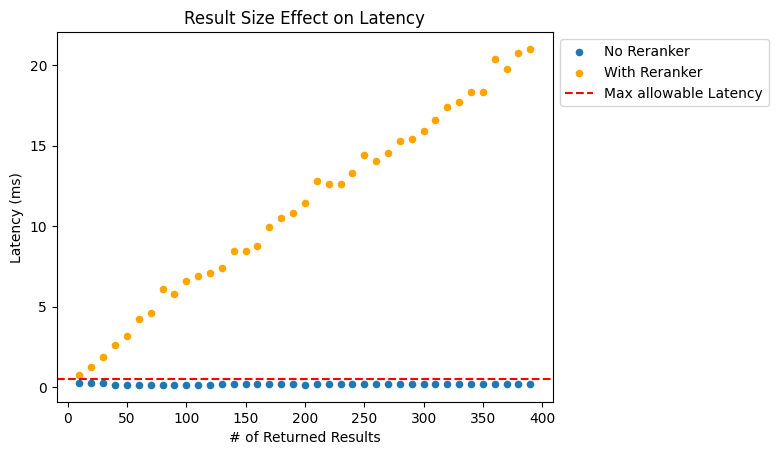

In [37]:
import time
import pandas as pd

def time_search(client: WeaviateWCS,
                collection_name: str,
                limit: int,
                rerank: bool
                ) -> float:
    '''
    Executes search given a limit value.
    Returns total time in seconds
    '''
    query = 'What is the best long term strategy for fat loss'
    start = time.perf_counter()
    response = client.hybrid_search(query, collection_name, limit=limit, return_properties=['content', 'title'])
    if rerank:
        reranked = reranker.rerank(response, query)
    end = time.perf_counter() - start
    return round(end, 3)

limit_values = list(range(10, 400, 10))

unranked_times = []
for n in tqdm(limit_values, 'Search: No Reranker'):
    unranked_times.append((time_search(client, collection_name, limit=n, rerank=False), n))


ranked_times = []
for n in tqdm(limit_values, 'Search: With Reranker'):
    ranked_times.append((time_search(client, collection_name, limit=n, rerank=True), n))



unranked = pd.DataFrame(unranked_times, columns=['time', 'n'])
ranked = pd.DataFrame(ranked_times, columns=['time', 'n'])

ax = unranked.plot.scatter(x='n', y='time', label='No Reranker', title='Result Size Effect on Latency')
ax2 = ranked.plot.scatter(x='n', y='time', ax=ax, color='orange', ylabel='Latency (ms)', label='With Reranker', xlabel='# of Returned Results')
hline = ax2.axhline(y = 0.5, color = 'r', linestyle = 'dashed', label = "Max allowable Latency")
legend = ax2.legend(bbox_to_anchor = (1.0, 1))

# Assignment 2.2 - New Retrieval Benchmark
***
**Reevaluate your retrieval results, this time using hybrid search and a Reranker** 

#### Instructions:
- Fill in the areas of the code wherever you see a `None` statement.  Use the `execute_evaluation` function to run your retrieval benchmark.
- `execute_evaluation` is the same function from Notebook 3, albeit with some modifications to incorporate hybrid search and Reranker functionality.
- Adjust the different hyperparameters to get the highest scoring retrieval score possible.

In [48]:
from src.database.database_utils import get_weaviate_client
from src.evaluation.retrieval_evaluation import execute_evaluation
from src.preprocessor.preprocessing import FileIO

from itertools import product

all_results = []

EMBEDDING_MODELS = [
    'sentence-transformers/all-MiniLM-L6-v2', # Baseline for the course
    # 'BAAI/bge-base-en-v1.5', # Higher ranked model on the MTEB
]
RERANKER_MODELS = [
    'cross-encoder/ms-marco-MiniLM-L-6-v2', # Baseline for the course
    # 'BAAI/bge-reranker-base', # Higher ranked model on the MTEB
]
# CHUNK_SIZES = [128, 256, 512]
# LIMITS = [50, 100, 250]
# ALPHAS = [0.25, 0.5, 0.75]

CHUNK_SIZES = [512]
LIMITS = [50]
ALPHAS = [0.5]

client = get_weaviate_client()
all_collections = client.show_all_collections()

for (embedding_model_name, reranker_model_name, chunk_size, limit, alpha) in product(EMBEDDING_MODELS, RERANKER_MODELS, CHUNK_SIZES, LIMITS, ALPHAS):
    base_model_name = embedding_model_name.split("/")[1].lower().replace("-", "_").replace(".", "")
    collection_name = f'Huberman_{base_model_name}_{chunk_size}'

    if collection_name not in all_collections:
        continue

    print(f'Running test on embedding model {embedding_model_name}, reranker model {reranker_model_name}, chunk size {chunk_size}, limit {limit}, alpha {alpha}...')

    client = get_weaviate_client(model_name_or_path=embedding_model_name)
    reranker = ReRanker(model_name=reranker_model_name)

    data_path = f'../data/golden_datasets/golden_{chunk_size}_hard.json'
    golden_dataset = FileIO().load_json(data_path)

    retrieval_results = execute_evaluation(dataset=golden_dataset, collection_name=collection_name, retriever=client, reranker=reranker, chunk_size=chunk_size, retrieve_limit=limit, alpha=alpha)
    all_results.append(retrieval_results)

Running test on embedding model sentence-transformers/all-MiniLM-L6-v2, reranker model 
cross-encoder/ms-marco-MiniLM-L-6-v2, chunk size 512, limit 50, alpha 0.5...

Queries:   2%|▏         | 2/100 [00:25<20:50, 12.76s/it]


KeyboardInterrupt: 

In [39]:
print(all_results)

[
    {
        'n': 50,
        'top_k': 5,
        'alpha': 0.5,
        'Retriever': 'sentence-transformers/all-MiniLM-L6-v2',
        'Ranker': 'cross-encoder/ms-marco-MiniLM-L-6-v2',
        'chunk_size': 512,
        'query_props': ['content'],
        'total_misses': 4,
        'total_questions': 100,
        'total_duration': 958.2727647079155,
        'duration_per_query': 9.582727647079155,
        'kw_hit_rate': 0.95,
        'kw_mrr': 0.84,
        'vector_hit_rate': 0.81,
        'vector_mrr': 0.75,
        'hybrid_hit_rate': 0.96,
        'hybrid_mrr': 0.84
    }
]

### Retrieval Score improvement

At this point in the course you have several options at your disposal to improve your retrieval score to maximize the relevance of the context that you will feed the LLM for the Question Answering phase of the system.  I'll list your options here, from least to most complex:
- Use hybrid search
- Experiment with the `alpha` parameter to see which value works best for this dataset
- Use a ReRanker
- Push the boundary on your reranker by maxing out the `retrieve_limit` value.  Try to keep latency below 500 ms.  
- Swap out your embedding model for a more performant one
- Find a better reranker on the MTEB leaderboard
- Fine-tune your embedding model
- Fine-tune your embedding model on a larger dataset than the 300 samples in the `training_data_300.json`.  You have the ability to create your own dataset through OpenAI and the `generate_finetune_datasets` notebook.
- Change the BM25 tokenizer

# Conclusion
***

Feel free to submit your new benchmark retrieval scores to move up on the Class Leaderboard!  I hope this notebook provided you with a better understanding of how Hybrid Search and CrossEncoders work under the hood.  
You are now prepared to move on to integrating your (high quality) retrieval results into an LLM for answer synthesis.  We'll next take a look at how we can build context options for the LLM and engineer our prompt to stack the deck in our favor.   Onward!